# Plotting the Pareto Front from WandB sweeps :

### Imports & Installs :

In [1]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import parallel_backend, Parallel, delayed
import tqdm

### Get run hashes and load run-table artifacts :  

In [26]:
api = wandb.Api()
entity = "algue"
project = "ICLR_Cifar10"
states = ["finished", "killed"]  # only runs that did not failed or crashed.
sweeps = {
  'acc_eps20_certacc_0' : 'q4zk798t',
  'acc_eps10_mult4': 'p1f5ix9a',
  'acc_eps10_mult2': 'ko4x40m8',
}
name_from_id = {v: k for k, v in sweeps.items()}
sweep_ids = list(sweeps.values())
filters = {"state": {"$in": states}, 'sweep': {"$in": sweep_ids}}  

redownload = True
if redownload:  
  runs = api.runs(entity + "/" + project, filters) 

In [27]:
faulty_runs = {}

def get_hist(run, add_config=True):
    # requires that n_epoch < 1024 to work ! (otherwise increase sample)
    hist = run.history(samples=2048)
    # check for empty runs
    if len(hist) == 0:
      faulty_runs[run.name] = "empty_run"
      return hist
    
    if "epsilon" not in hist.columns:
      faulty_runs[run.name] = "no_epsilon"
      return hist
    
    # re-order columns and reindex data
    hist = hist.sort_values(by=["epoch", "_step"], axis=0)
    hist = hist.reset_index(drop=True)

    # backward fill the "epsilon" field (reported on epoch+1)
    hist = hist.fillna(method='bfill', limit=2)
    # hist = hist.fillna(method='ffill', limit=2)  # for mia-attacks.

    # drop row where epsilon is not known
    hist = hist.dropna(how="any", subset=["epsilon", "val_accuracy"], axis=0)

    # take one value out of two
    hist = hist.iloc[::2, :]

    if len(hist) == 0:
      faulty_runs[run.name] = "empty_run"
      return hist

    hist['name'] = run.name
    hist['sweep'] = name_from_id[run.sweep.id]
    if add_config:
      for k, v in run.config.items():
        hist[k] = v
    hist['num_epochs'] = len(hist)
    hist['run_id'] = run.id
    
    return hist

if redownload:
  n_jobs = 10
  histories = []
  debug = False
  num_runs = 50 if debug else len(runs)
  with parallel_backend(backend='threading', n_jobs=n_jobs, require='sharedmem'):
    pfor = Parallel(n_jobs=n_jobs)(delayed(get_hist)(run, add_config=not debug) for run in tqdm.tqdm(runs[:num_runs]))
    for metrics_dataframe in tqdm.tqdm(pfor):
      histories.append(metrics_dataframe)
  histories = pd.concat(histories)
  histories = histories.dropna(how="any", subset=["epsilon", "val_accuracy"], axis=0)
  histories = histories.dropna(how="all", axis=1)
  histories = histories.sort_values(by=["num_epochs", "name", "epoch", "_step"], axis=0)
  faulty_runs = pd.DataFrame.from_dict(faulty_runs, orient="index", columns=["reason"])

100%|██████████| 99/99 [00:00<00:00, 438475.29it/s]


In [28]:
if redownload:
  histories.to_csv("multiaug.csv", index=False)

In [29]:
histories = pd.read_csv("multiaug.csv")

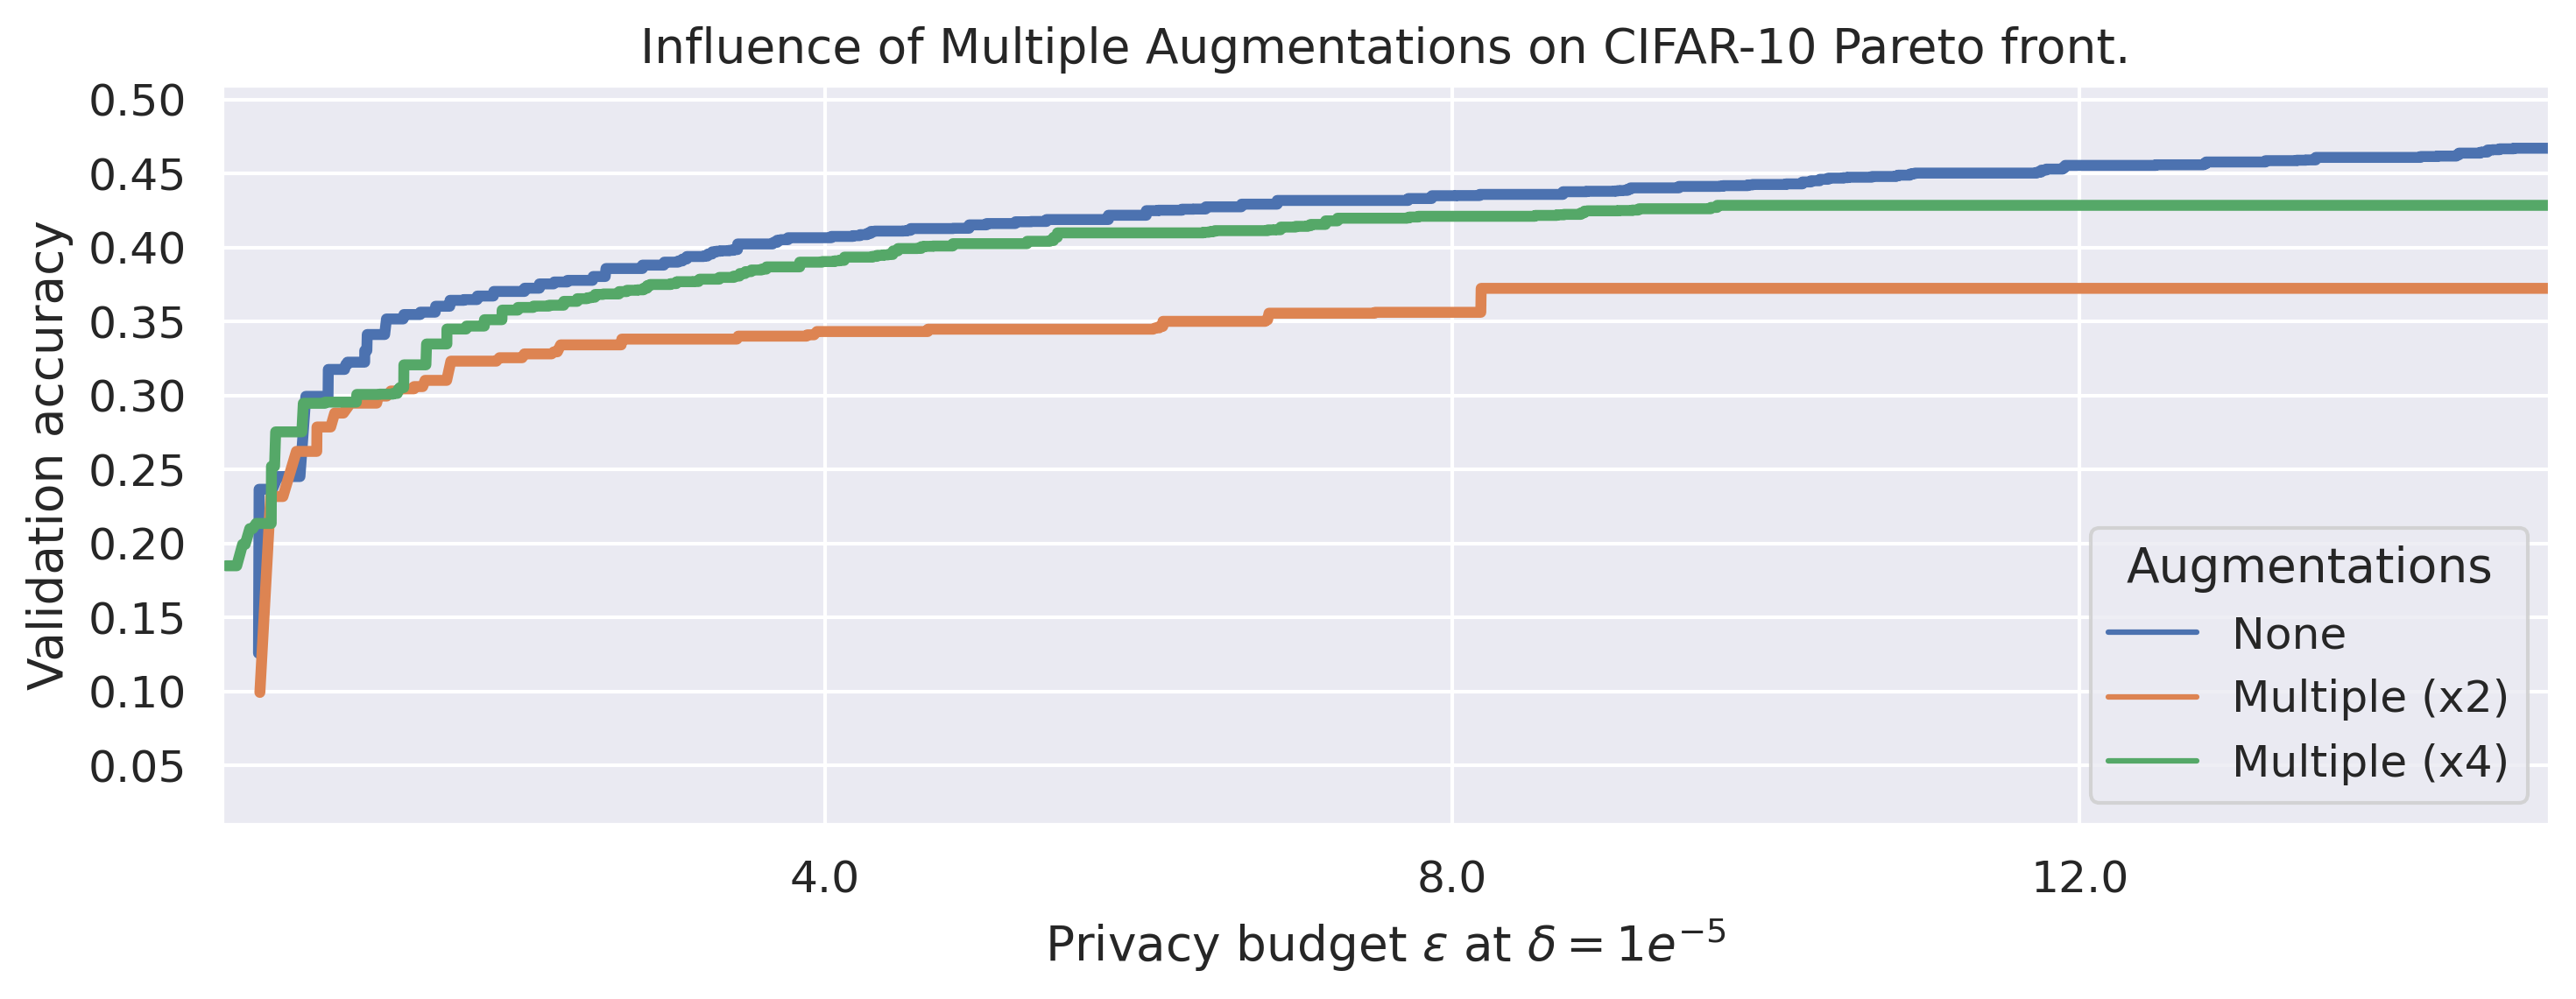

In [34]:
import seaborn as sns
import math

sns.set_context("paper")

def plot_all_datasets():
  num_cols = 1
  num_rows = 1
  unit_row = 4
  unit_col = 10
  sns.set(rc={'figure.figsize':(num_cols * unit_col, num_rows * unit_row)})
  sns.set(font_scale=1.1)
  plt.gcf().set_dpi(300)

  name_from_code = {
    "acc_eps20_certacc_0": "None",
    "acc_eps10_mult2": "Multiple (x2)",
    "acc_eps10_mult4": "Multiple (x4)",
  }

  df = {}

  for sweep_name in name_from_code:
    delta = 5

    name = name_from_code[sweep_name]

    histories_radius = histories[histories["sweep"] == sweep_name]
    pareto_front = histories_radius.set_index("epsilon").sort_values("epsilon")
    pareto_front = pareto_front["val_accuracy"].expanding().max()

    df[sweep_name] = pd.DataFrame.from_dict({
      "epsilon": pareto_front.index,
      "metric": pareto_front.values,
      "Augmentations": name,
    })
    
  # stack of dataframes
  df = pd.concat(df.values(), ignore_index=True, axis=0)
  ax = sns.lineplot(
    data=df,
    x='epsilon',
    y='metric',
    hue='Augmentations',
    lw=3,
    errorbar=None,
    zorder=2)

  ticks = [4.0, 8.0, 12.0, 16.0, 20.0]
  labels = [str(v) for v in ticks]
  ax.set_xticks(ticks, labels=labels)
  ax.set(xlim=(0.15, 15.0))

  yticks = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
  ylabels = list(map(lambda v: f"{v:.2f}", yticks))
  ax.set_yticks(yticks, labels=ylabels)
  ax.set(ylim=(0.01, 0.51))

  ax.set_xlabel(f"Privacy budget $\epsilon$ at $\delta=1e^{{{-delta}}}$")
  ax.set_ylabel("Validation accuracy") 

  ax.set_title("Influence of Multiple Augmentations on CIFAR-10 Pareto front.")

  # ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))

  plt.tight_layout()
  plt.savefig('multiaug.png', dpi=300, bbox_inches='tight')

plot_all_datasets()